# KITTI Object detection

In [1]:
# import libraries
import os, copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

from time import time

DATA_PATH = os.getenv('HOME') + '/aiffel/object_detection/data'


In [2]:
tf.__version__

'2.6.0'

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_PATH,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)


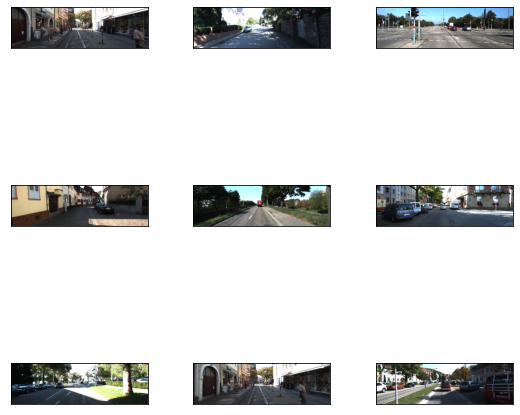

In [4]:
_ = tfds.show_examples(ds_train, ds_info)

In [5]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/aiffel/object_detection/data/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
     

### Dataset Feature	설명
---
- alpha	객체의 관측각(Observation Angle, 방향 정보)
- bbox	2D 바운딩 박스 좌표 (y_min, x_min, y_max, x_max) (좌하단이 원점인 y, x 좌표를 표기하고 있음)
- dimensions	객체 크기 (길이, 너비, 높이)
- location	객체의 3D 위치 좌표 (x, y, z)
- occluded	객체 가려짐 상태 (0: 가려지지 않음, 1: 부분적으로 가려짐, 2: 상당 부분 가려짐, 3: 완전히 가려짐)
- rotation_y	객체의 y축 회전값 (yaw rotation)
- truncated	객체의 잘림 정도 (0.0~1.0, 값이 클수록 잘림이 심함)
- type	객체 클래스 (총 8개 카테고리, 차량/보행자 등)

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-1.42, -1.08,  2.05], dtype=float32)>, 'bbox': <tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0.48684493, 0.46631664, 0.54419786, 0.49243134],
       [0.4390107 , 0.39300483, 0.5371925 , 0.45189014],
       [0.45713905, 0.2655735 , 0.54676473, 0.32101777]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1.43, 1.66, 4.15],
       [1.48, 1.56, 3.62],
       [1.68, 1.67, 4.29]], dtype=float32)>, 'location': <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[ -0.5 ,   0.69,  50.49],
       [ -3.3 ,   1.13,  30.82],
       [-12.65,   1.07,  38.43]], dtype=float32)>, 'occluded': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([0, 0, 1])>, 'rotation_y': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-1.44, -1.19,  1.73], dtype=float32)>, 'truncated': <tf.Tensor: shape=(3,), dtype=float32, numpy

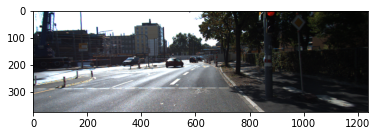

In [6]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show()

In [7]:
img.size

(1238, 374)

o: [486.5399852991104, 164.19000536203384, 559.4399942755699, 200.91000378131866]
fix: [486.53998 209.81    559.44    173.09   ]


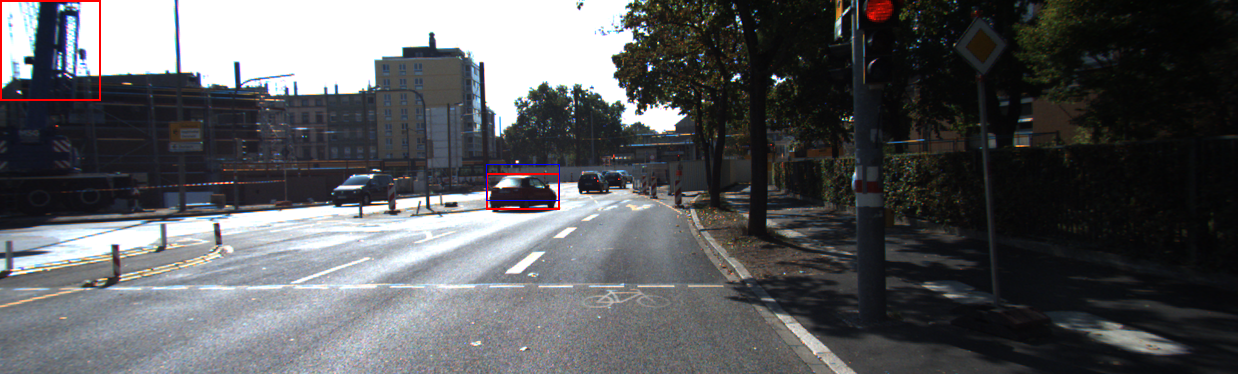

In [8]:
from PIL import ImageDraw

def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    img_draw = ImageDraw.Draw(input_image)

    
    width, height = img.size
    x_min = object_bbox[:,1] * width
    y_min = height - object_bbox[:,0] * height
    x_max = object_bbox[:,3] * width
    y_max = height - object_bbox[:,2] * height        

    img_draw.rectangle([0,0, 100, 100], outline=(255,0,0), width=2)

    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for i, _rect in enumerate(rects):
        if i == 1:
            img_draw.rectangle(_rect, outline=(255,0,0), width=2)    
            o_x_min = object_bbox[:,1][i] * width
            o_y_min = object_bbox[:,0][i] * height
            o_x_max = object_bbox[:,3][i] * width
            o_y_max = object_bbox[:,2][i] * height
            img_draw.rectangle([o_x_min, o_y_min, o_x_max, o_y_max], outline='blue')
            print("o:",[o_x_min, o_y_min, o_x_max, o_y_max])
            print("fix:", _rect)


    return input_image

visualize_bbox(img, objects['bbox'].numpy())

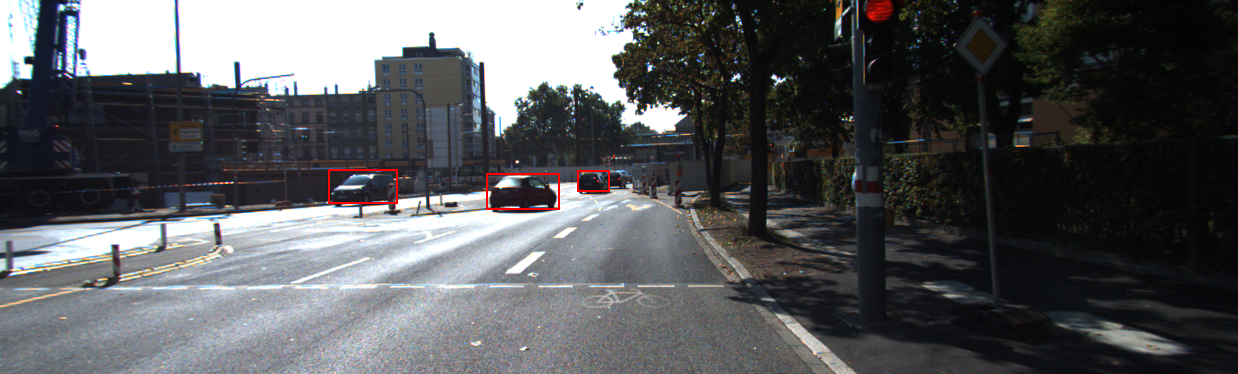

In [9]:
from PIL import ImageDraw

def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    img_draw = ImageDraw.Draw(input_image)

    
    width, height = img.size
    x_min = object_bbox[:,1] * width
    y_min = height - object_bbox[:,0] * height
    

    x_max = object_bbox[:,3] * width
    y_max = height - object_bbox[:,2] * height        
    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for i, _rect in enumerate(rects):
        img_draw.rectangle(_rect, outline=(255,0,0), width=2)

    return input_image

visualize_bbox(img, objects['bbox'].numpy())

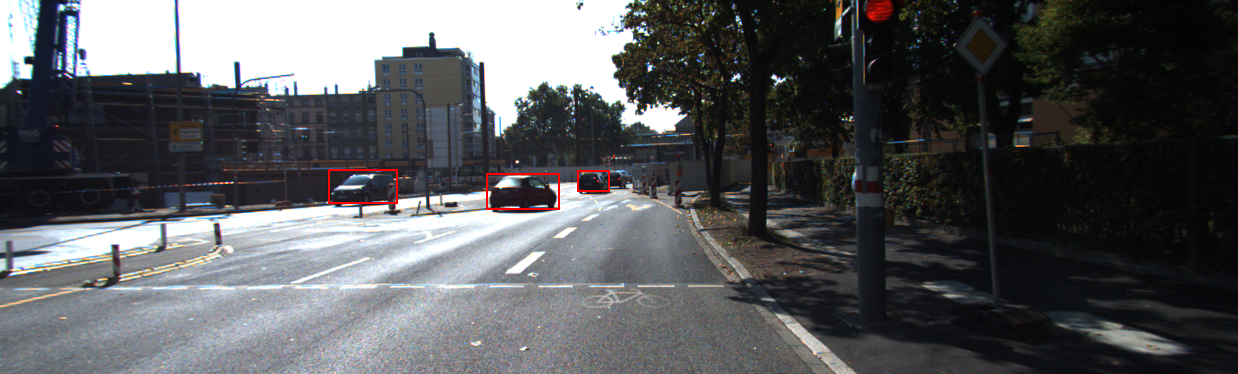

In [10]:
from PIL import ImageDraw

# 이미지 위에 바운딩 박스를 그려 화면에 표시해 주세요.
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    img_draw = ImageDraw.Draw(input_image)


    for bbox in object_bbox:

        # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
        x_min = bbox[1] * input_image.size[0]
        x_max = bbox[3] * input_image.size[0]
        y_min = (1-bbox[0]) * input_image.size[1]
        y_max = (1-bbox[2]) * input_image.size[1]

        # 바운딩 박스 그리기
        img_draw.rectangle([x_min, y_min, x_max, y_max], outline='red', width=2)

    return input_image

visualize_bbox(img, objects['bbox'].numpy())

## 간단한 자율주행 보조 소프트웨어 만들기

In [11]:
# 데이터 전처리
# x와 y좌표 위치 교체(KITTI tensorflow dataset)
# 무작위로 수평 뒤집기(Flip)
# 이미지 크기 조정 및 패딩 추가
# 좌표계를 [x_min, y_min, x_max, y_max]에서 [x_min, y_min, width, height]으로 수정
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)


In [12]:
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
           [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
        
    return image, boxes

In [13]:
# 전처리시 이미지의 비율 유지되어야 하고, 이미지의 최대/최소 크기도 제한해야 함
# 그외; 최종적으로 모델에 입력되는 이미지의 크기는 stride의 배수가 되도록 함

In [14]:
def resize_and_pad_image(image, training=True):

    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio


In [15]:
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

In [16]:
def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

In [17]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)


In [18]:
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)


In [19]:
class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()


In [20]:
class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output


In [21]:
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head


In [22]:
def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )


In [23]:
class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)


In [24]:
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes
        # @TODO
        self.sum_clf_loss = tf.Variable(0.0, trainable=False)
        self.sum_box_loss = tf.Variable(0.0, trainable=False)
        self.count = tf.Variable(0.0, trainable=False)
        self.mean_clf_loss = tf.Variable(0.0, trainable=False)
        self.mean_box_loss = tf.Variable(0.0, trainable=False)
        
        self.clf_loss = tf.Variable(0.0, trainable=False)
        self.box_loss = tf.Variable(0.0, trainable=False)
                
    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1) 

        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)

        # update batch clf_loss and box_loss attributes
        self.clf_loss = tf.reduce_mean(clf_loss)
        self.box_loss = tf.reduce_mean(box_loss)
        #self.class_loss.assign(class_loss)
        #self.box_loss.assign(box_loss * self.alpha)
        
        # update batch mean loss
        self.sum_clf_loss.assign_add(tf.reduce_sum(clf_loss))
        self.sum_box_loss.assign_add(tf.reduce_sum(box_loss))
        self.count.assign_add(tf.cast(y_true.shape[0], dtype='float32'))
        self.mean_clf_loss = tf.math.divide_no_nan(self.sum_clf_loss, self.count)
        self.mean_box_loss = tf.math.divide_no_nan(self.sum_box_loss, self.count)
        
        loss = clf_loss + box_loss
        
        
        return loss


In [25]:
del model

NameError: name 'model' is not defined

In [26]:
# 즉시 실행 모드 활성화 (기본값)
tf.config.run_functions_eagerly(True)

num_classes = 8
batch_size = 2

resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)

model = RetinaNet(num_classes, resnet50_backbone)


In [27]:
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer)

# Dataset

In [28]:
label_encoder = LabelEncoder()
(train_dataset, val_dataset), dataset_info = tfds.load(
    "kitti", split=["train", "validation"], with_info=True, data_dir=DATA_PATH
)

autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.prefetch(autotune)


/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


# Training

In [29]:
import sys

class LossCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.total_losses = []
        self.clf_losses = []
        self.box_losses = []
    
        
    def on_train_batch_end(self, batch, logs=None):
        if logs is not None:
            logs['clf_loss'] = tf.keras.backend.get_value(self.model.loss.clf_loss)
            logs['box_loss'] = tf.keras.backend.get_value(self.model.loss.box_loss)

            logs['mean_clf_loss'] = tf.keras.backend.get_value(self.model.loss.mean_clf_loss)
            logs['mean_box_loss'] = tf.keras.backend.get_value(self.model.loss.mean_box_loss)
            
            # 로스값
            # 모델의 개별 손실 값 추출 (logs에서 가져오기)
            clf_loss = logs.get('clf_loss', 0.0)
            box_loss = logs.get('box_loss', 0.0)
            loss = logs.get('loss', 0.0)

            # 모든 로스 기록
            self.total_losses.append(loss)
            self.clf_losses.append(clf_loss)
            self.box_losses.append(box_loss)
            mean_clf_loss = logs['mean_clf_loss']
            mean_box_loss = logs['mean_box_loss']
    

            # 로스 출력 : batch loss, batch bbox los, batch clf loss, mean box loss, mean clf loss
            #print("clf_loss:",clf_loss, "box_loss:",box_loss, "loss:",loss, \
            #      "mean_clf_loss:", logs['mean_clf_loss'], "mean_box_loss:", logs['mean_box_loss'])
            sys.stdout.write(f"\rIteration {batch+1} - Loss: {loss:.4f}, bbox_loss:{box_loss}, class_loss:{clf_loss}, mean_bbox_loss:{mean_box_loss}, mean_clf_loss:{mean_clf_loss}")
            sys.stdout.flush()

In [30]:
print(model.loss.clf_loss)
print(tf.reduce_sum(model.loss.clf_loss))
print(model.loss.box_loss)
print(tf.reduce_sum(model.loss.box_loss))
print(model.loss.sum_clf_loss)
print(model.loss.sum_box_loss)
print(model.loss.count)
print(type(tf.keras.backend.get_value(model.loss.mean_clf_loss)))

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>
tf.Tensor(0.0, shape=(), dtype=float32)
<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>
tf.Tensor(0.0, shape=(), dtype=float32)
<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>
<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>
<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>
<class 'numpy.float32'>


In [31]:
model_dir = os.getenv('HOME') + '/aiffel/object_detection/'

callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    )
]
# Callbacks
log_dir = os.path.join(model_dir, "logs")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks_list.append(tensorboard_callback)

# Instantiate the callback
loss_callback = LossCallback()
callbacks_list.append(loss_callback)

epochs = 1

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=callbacks_list
)

3173/3173 [==============================] - 1976s 618ms/step - loss: 2.3934 - val_loss: 1.6332_bbox_loss:1.6695139408111572, mean_clf_loss:0.723888397216796

Epoch 00001: saving model to /aiffel/aiffel/object_detection/weights_epoch_1


In [32]:
import matplotlib.pyplot as plt

# 학습 후 loss 그래프 시각화
def plot_losses(loss_tracker):
    plt.figure(figsize=(10, 6))
    plt.plot(loss_tracker.total_losses, label="Total Loss", color='red')
    plt.plot(loss_tracker.clf_losses, label="Classification Loss", color='blue')
    plt.plot(loss_tracker.box_losses, label="Box Loss", color='green')

    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Loss Visualization After Training")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses(model.loss)

AttributeError: 'RetinaNetLoss' object has no attribute 'total_losses'

<Figure size 720x432 with 0 Axes>

In [72]:
model_dir = os.getenv('HOME') + '/aiffel/object_detection/'
model.save(model_dir)

INFO:tensorflow:Assets written to: /aiffel/aiffel/object_detection/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/object_detection/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [73]:
model_dir = os.getenv('HOME') + '/aiffel/object_detection/data/checkpoints/'
latest_checkpoint = tf.train.latest_checkpoint(model_dir)
model.load_weights(latest_checkpoint)


In [74]:
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )


In [75]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

In [76]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        origin_x, origin_y = x1, image.shape[0] - y2 # matplitlib에서 Rectangle와 text를 그릴 때는 좌하단이 원점이고 위로 갈 수록 y값이 커집니다
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [origin_x, origin_y], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax


In [77]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio


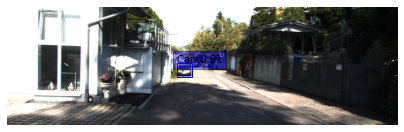

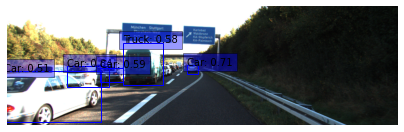

In [78]:
test_dataset = tfds.load("kitti", split="test", data_dir=DATA_PATH)
int2str = dataset_info.features["objects"]["type"].int2str

for sample in test_dataset.take(2):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

# Stop and go drive assistant

In [79]:

import tensorflow as tf

print(tf.__version__)

img_path = os.getenv('HOME')+'/aiffel/object_detection/data/stop_1.png'

def self_drive_assist(img_path, size_limit=300):
    # 코드 구현
        # 정지조건에 맞으면 return "Stop"
        # 아닌 경우 return "Go"

print(self_drive_assist(img_path))

import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
    score = 0
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)

IndentationError: expected an indented block (3363602960.py, line 12)

In [ ]:
회고